<a href="https://colab.research.google.com/github/c-gohlke/X_Ray-patients-classification/blob/master/MURA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anomaly Detection for Hand X-Ray Images

The topic of this project is to be able to classify whether X-ray images of hands are normal or abnormal. In this notebook, I will apply 3 algorithms for image classification, explain how they function and how they are implemented, as well as show my results.


##Part 1: Data loading and preprocessing

We have access to the MURA (musculoskeletal radiographs) dataset, one of the largest public radiographic datasets. It has images of 15000 patient's X-ray images for various body parts, where each patient is classified as "normal" or "abnormal". 

For each patient, the amount of images provided ranges from 1 to 4.

First of all, we have to download the dataset, which is stored in my Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#mute output
%%capture

!unzip '/content/drive/My Drive/projects/MURA/MURA-v1.1.zip'

In [3]:
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate, ReLU, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import random
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import pickle
import sys
from skimage.color import rgb2gray
from skimage.transform import resize

We now need to load the images. The file 'MURA-v1.1/train_labeled_studies.csv' contains the path to each patient alongside the patient's diagnosis.

Each of the patient's images is loaded and resized to the defined dimension of (220,220,3)


In [ ]:
labels_amount = 2
img_dim = (220, 220, 3)

def load_images(img_dim, path):
    df = pd.read_csv(path)

    x = []
    Y = []
    for i in range(len(df)):
        dirList = os.listdir(df["PATH"][i])
        for dir in dirList:
            img = mpimg.imread(df["PATH"][i] + dir) #mpimg loads images with values 0 to 1, no need to rescale
            image_resized = resize(img, img_dim)

            x.append(image_resized)
            Y.append(df["DIAGNOSIS"][i])

    return np.asarray(x), np.asarray(Y)

Because the loading and resizing is slow, we save the training and testing sets such that they don't have to be recomputed at each run.

In [ ]:
X_train, y_train = load_images(img_dim, 'MURA-v1.1/train_labeled_studies.csv')
X_test, y_test = load_images(img_dim, 'MURA-v1.1/valid_labeled_studies.csv')

with open('/content/drive/My Drive/projects/MURA/files/X_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/projects/MURA/files/y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/projects/MURA/files/X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/projects/MURA/files/y_test.pickle', 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/My Drive/projects/MURA/files/X_train.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([4059, 1484]))
(array([0, 1]), array([271, 189]))


We see that the datasets are very imbalanced. There are 4330 normal patients, while there is only 1673 abnormal patients.

This will encourage the model to predict "abnormal" much more often than "normal".

To solve this problem, we can apply class weights according to the frequency of the classes, or we can resample the dataset such that it is balanced.

Resampling the dataset also allows the accuracy metric to be more intuitive. Indeed, a model that always predicts "normal" will have an accuracy of ~75%, even though the model doesn't make any meaningful predictions.

The evaluation metrics used are the accuracy score and the cohen-kappa-score.

The cohen-kappa-score is a statistic used to measure the interrater reliability, whose value ranges from -1 to 1. It provides an indication of how similar two arrays are, compared to what would be expected from a model that predicts at random.

A model that always predicts "normal", independently of the input image, would score an accuracy of ~75%, but would get a cohen-kappa score of ~0.

In [ ]:
true_train_idx, = np.where(y_train == 1)
false_train_idx, = np.where(y_train == 0)
true_test_idx, = np.where(y_test == 1)
false_test_idx, = np.where(y_test == 0)

np.random.seed(0)
false_train_idx_sampled = np.random.choice(false_train_idx, len(true_train_idx), replace=False)
false_test_idx_sampled = np.random.choice(false_test_idx, len(true_test_idx), replace=False)

resample_train_idx = np.concatenate((true_train_idx, false_train_idx_sampled))
resample_test_idx = np.concatenate((true_test_idx, false_test_idx_sampled))

X_train_balanced = X_train[resample_train_idx]
X_test_balanced = X_test[resample_test_idx]
y_train_balanced = y_train[resample_train_idx]
y_test_balanced = y_test[resample_test_idx]

In [ ]:
y_train_cat = to_categorical(y_train_balanced, labels_amount)
y_test_cat = to_categorical(y_test_balanced, labels_amount)

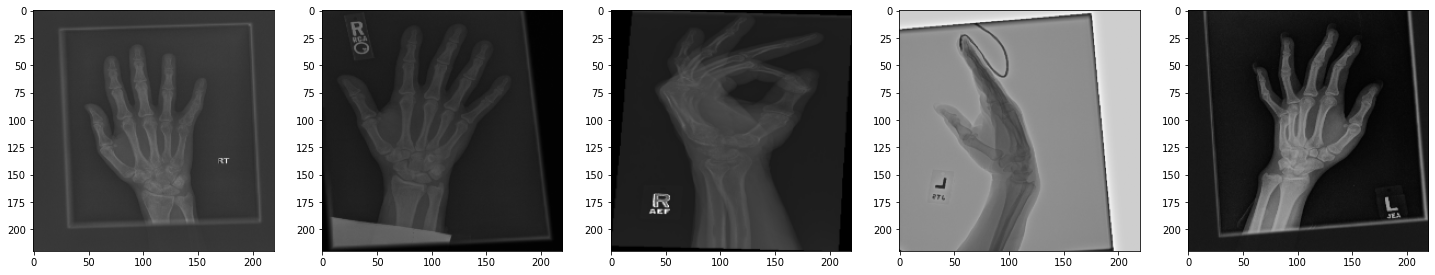

In [ ]:
#example of images:
example_img1 = X_train_balanced[0]
example_img2 = X_train_balanced[100]
example_img3 = X_train_balanced[200]
example_img4 = X_train_balanced[1900]
example_img5 = X_train_balanced[2000]

fig, axes = plt.subplots(1, 5, figsize=(25, 25))
ax = axes.ravel()

ax[0].imshow(example_img1)
ax[1].imshow(example_img2)
ax[2].imshow(example_img3)
ax[3].imshow(example_img4)
ax[4].imshow(example_img5)
plt.show()

##PART 2: Classification using Logistic Regression




Logistic Regression is a regression analysis method that is applicable on classification problems with 2 possible outcomes. 

Logistic regression is a linear classifier that predicts the probability of a hand being normal or abnormal.

It performs well on simple image classification tasks such as MNIST, but struggles with more complex image classification tasks due to its linearity and inability to make sense of spatial information.

In [ ]:
def train_logreg():
    #create the model
    labels_amount = 2
    batch_size = 64

    model = Sequential()
    model.add(Flatten())
    model.add(Dense(labels_amount, input_dim=img_dim[0]*img_dim[1], activation='softmax')) 

    model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

    epochs = 100

    #disproportionate amount of 0s in training set, so we assign a higher weight to the "1" class
    #does nothing when dataset is balanced
    # count0 = np.count_nonzero(y_train==0)
    # count1 = np.count_nonzero(y_train==1)
    # class_weight = {0:count1/(count1+count0), 1:1}
    
    checkpoint = ModelCheckpoint('/content/drive/My Drive/projects/MURA/models/LogReg.h5', monitor='val_acc',save_best_only=True)

    history = model.fit(X_train_balanced, y_train_cat, batch_size=batch_size, epochs=epochs, class_weight=None, callbacks=[checkpoint], validation_data=(X_test_balanced, y_test_cat))

    return model, history

In [ ]:
model, history = train_logreg()

Train on 2968 samples, validate on 378 samples
Epoch 1/100
2968/2968 [==============================] - 1s 406us/step - loss: 11.4860 - accuracy: 0.4916 - val_loss: 12.7909 - val_accuracy: 0.5000
Epoch 2/100
 448/2968 [===>..........................] - ETA: 0s - loss: 13.2792 - accuracy: 0.4665

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2968/2968 [==============================] - 1s 384us/step - loss: 11.1926 - accuracy: 0.5003 - val_loss: 10.6433 - val_accuracy: 0.5000
Epoch 3/100
2968/2968 [==============================] - 1s 381us/step - loss: 11.0406 - accuracy: 0.5034 - val_loss: 12.0971 - val_accuracy: 0.5000
Epoch 4/100
2968/2968 [==============================] - 1s 382us/step - loss: 11.4696 - accuracy: 0.4902 - val_loss: 2.1445 - val_accuracy: 0.5952
Epoch 5/100
2968/2968 [==============================] - 1s 382us/step - loss: 10.4003 - accuracy: 0.5074 - val_loss: 13.6413 - val_accuracy: 0.5000
Epoch 6/100
2968/2968 [==============================] - 1s 382us/step - loss: 10.9879 - accuracy: 0.5074 - val_loss: 20.9140 - val_accuracy: 0.5000
Epoch 7/100
2968/2968 [==============================] - 1s 387us/step - loss: 10.2809 - accuracy: 0.5121 - val_loss: 1.3636 - val_accuracy: 0.6138
Epoch 8/100
2968/2968 [==============================] - 1s 385us/step - loss: 10.5639 - accuracy: 0.5061 - val_loss: 16

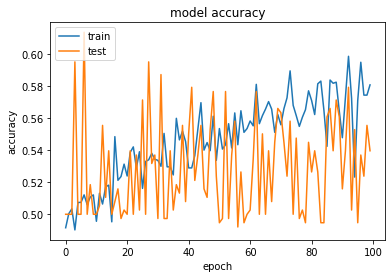

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/drive/My Drive/projects/MURA/plots/LogReg-history.png')

In [ ]:
#ANALYSIS ON VALIDATION SET
from sklearn.metrics import cohen_kappa_score

pred = model.predict(X_test_balanced)

#convert array with values of form [[0.4, 0.6],...,[0.9, 0.1]] to [1,0] 
y_hat = np.zeros(len(pred))
for i in range(len(pred)):
    y_hat[i] = np.argmax(pred[i])

kappa = cohen_kappa_score(y_test_balanced, y_hat)
print ("cohen-kappa score is", kappa)

score = model.evaluate(X_test_balanced, y_test_cat, verbose=0)

print("For logreg, accuracy is: {}, cohen-kappa-score is: {}, loss is: {}".format(score[1], kappa, score[0]))
print("metrics are", model.metrics_names)
print("respective scores are", score)

As we can see, Logistic Regression is not able to model complex image classification problems in any meaningful way.

Convolutional Neural Networks are the state-of-the art for Image Classification problems and are much more adapted to this type of problem.

##PART3: SINGLE-INPUT Convolutional Neural Net

Convolutional Neural Nets are the current state-of-the art for image classification. The advantages of CNNs as opposed to regular Multilayered Perceptrons are that they use kernels/filters that apply a mathematical function to many subsets of adjacent pixels of the picture. Moving accross the image, the kernel is applied to each subset of pixels (usually 3*3 or 5*5).
The kernel captures, for example, how closely a set of pixels resembles a specific shape, independently of that pixel set’s location on the picture. This means that a kernel that recognizes, for example, a cat, will be able to recognize it independently of the location of the cat in the picture. This is one of the strengths of a CNN.
After the filters have passed over the image, a feature map is generated for each filter. These are taken through an activation function, which decides whether a certain feature is present at a given location in the image.

In [ ]:
filters = 64
kernel_size = (5, 5)
pool_size = (3, 3)
batch_size = 64

In [ ]:
def train(img_dim, epochs):
    #create the model
    model = Sequential()
    model.add(Convolution2D(filters, (kernel_size[0], kernel_size[1]),
                            input_shape=img_dim))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters, (kernel_size[0], kernel_size[1])))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Convolution2D(filters, (kernel_size[0], kernel_size[1])))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(filters, (kernel_size[0], kernel_size[1])))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(labels_amount))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics= ['accuracy']
                )

    #disproportionate amount of 0s in training set, so we assign a higher weight to the "1" class

    #does nothing when classes are balanced
    # count0 = np.count_nonzero(Y_train==0)
    # count1 = np.count_nonzero(Y_train==1)

    # class_weight = {0:count1/(count1+count0), 1:1}

    checkpoint = ModelCheckpoint('/content/drive/My Drive/projects/MURA/models/CNN.h5', monitor='val_accuracy',save_best_only=True)

    history = model.fit(X_train_balanced, y_train_cat, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=(X_test_balanced, y_test_cat))
    
    # model.save("/content/drive/My Drive/projects/MALIS/CNN.h5")
    return model, history

In [ ]:
epochs = 50
model, history = train(img_dim, epochs)

Train on 2968 samples, validate on 378 samples
Epoch 1/50
2968/2968 [==============================] - 19s 7ms/step - loss: 0.9969 - accuracy: 0.5202 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 2/50


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2968/2968 [==============================] - 19s 6ms/step - loss: 0.6943 - accuracy: 0.5509 - val_loss: 0.6954 - val_accuracy: 0.4259
Epoch 3/50
2968/2968 [==============================] - 19s 6ms/step - loss: 0.6888 - accuracy: 0.5455 - val_loss: 0.6989 - val_accuracy: 0.4603
Epoch 4/50
2968/2968 [==============================] - 19s 6ms/step - loss: 0.6839 - accuracy: 0.5553 - val_loss: 0.7008 - val_accuracy: 0.4788
Epoch 5/50
2968/2968 [==============================] - 19s 6ms/step - loss: 0.6839 - accuracy: 0.5650 - val_loss: 0.7073 - val_accuracy: 0.4788
Epoch 6/50
2968/2968 [==============================] - 19s 6ms/step - loss: 0.6737 - accuracy: 0.5799 - val_loss: 0.7028 - val_accuracy: 0.4286
Epoch 7/50
2968/2968 [==============================] - 19s 6ms/step - loss: 0.6806 - accuracy: 0.5724 - val_loss: 0.7128 - val_accuracy: 0.4365
Epoch 8/50
2968/2968 [==============================] - 19s 6ms/step - loss: 0.6743 - accuracy: 0.5805 - val_loss: 0.7002 - val_accuracy: 0.4

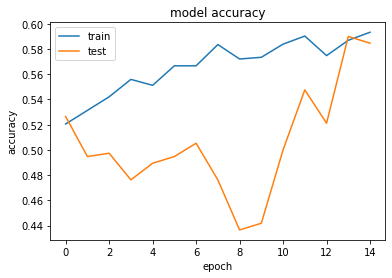

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/drive/My Drive/projects/MURA/plots/CNN-history.png')

In [ ]:
model = load_model("/content/drive/My Drive/projects/MURA/models/CNN-0,46.h5")

In [ ]:
#ANALYSIS ON VALIDATION SET
pred = model.predict(X_test_balanced)

#convert array with values of form [[0.4, 0.6],...,[0.9, 0.1]] to [1,0] 
y_hat = np.zeros(len(pred))
for i in range(len(pred)):
    y_hat[i] = np.argmax(pred[i])

kappa = cohen_kappa_score(y_test_balanced, y_hat)
print ("cohen-kappa score is", kappa)

score = model.evaluate(X_test_balanced, y_test_cat, verbose=0)
print("metrics are", model.metrics_names)
print("respective scores are", score)

amount of times guessed abnormal 180
cohen-kappa score is 0.4444444444444444
metrics are ['loss', 'accuracy']
respective scores are [0.5882318615913391, 0.7222222089767456]


Advanced prediction. End goal is to predict patient diagnosis, not image. So we combine prediction for each of patient's images to give a prediction for the patient

In [ ]:
with open('/content/drive/My Drive/projects/MURA/files/X_train1_balanced.pickle', 'rb') as handle:
    X_train1_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_train2_balanced.pickle', 'rb') as handle:
    X_train2_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_train3_balanced.pickle', 'rb') as handle:
    X_train3_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_train4_balanced.pickle', 'rb') as handle:
    X_train4_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test1_balanced.pickle', 'rb') as handle:
    X_test1_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test2_balanced.pickle', 'rb') as handle:
    X_test2_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test3_balanced.pickle', 'rb') as handle:
    X_test3_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test4_balanced.pickle', 'rb') as handle:
    X_test4_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/y_train_balanced.pickle', 'rb') as handle:
    y_train_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/y_test_balanced.pickle', 'rb') as handle:
    y_test_balanced = pickle.load(handle)

In [ ]:
y_train_cat = to_categorical(y_train_balanced, labels_amount)
y_test_cat = to_categorical(y_test_balanced, labels_amount)

In [ ]:
model = load_model("/content/drive/My Drive/projects/MURA/models/CNN-0,46.h5")

In [ ]:
y_hat = np.zeros((len(y_test_balanced), 1))

for i in range(0,len(y_test_balanced)):
    pred1 = [[0,0]]
    pred2 = [[0,0]]
    pred3 = [[0,0]]
    pred4 = [[0,0]]

    zero_image = np.zeros((220,220,3))

    if(not np.array_equal(X_test1_balanced[i], zero_image) ):
        pred1 = model.predict(X_test1_balanced[i].reshape(1,220,220,3))

    if(not np.array_equal(X_test2_balanced[i], np.zeros((220,220,3)))):
        pred2 = model.predict(X_test2_balanced[i].reshape(1,220,220,3))

    if(not np.array_equal(X_test3_balanced[i], np.zeros((220,220,3)))):
        pred3 = model.predict(X_test3_balanced[i].reshape(1,220,220,3))

    if(not np.array_equal(X_test4_balanced[i], np.zeros((220,220,3)))):
        pred4 = model.predict(X_test4_balanced[i].reshape(1,220,220,3))

    pred = [pred1[0][0] + pred2[0][0] + pred3[0][0] + pred4[0][0] , pred1[0][1] + pred2[0][1] + pred3[0][1] + pred4[0][1]]
    y_hat[i] = np.argmax(pred)

In [ ]:
y_hat = np.zeros((len(y_test_balanced), 1))

for i in range(0,len(y_test_balanced)):
    pred1 = [[0,0]]
    pred2 = [[0,0]]
    pred3 = [[0,0]]
    pred4 = [[0,0]]

    zero_image = np.zeros((220,220,3))

    if(not np.array_equal(X_test1_balanced[i], zero_image) ):
        pred1 = model.predict(X_test1_balanced[i].reshape(1,220,220,3))

    if(not np.array_equal(X_test2_balanced[i], np.zeros((220,220,3)))):
        pred2 = model.predict(X_test2_balanced[i].reshape(1,220,220,3))

    if(not np.array_equal(X_test3_balanced[i], np.zeros((220,220,3)))):
        pred3 = model.predict(X_test3_balanced[i].reshape(1,220,220,3))

    if(not np.array_equal(X_test4_balanced[i], np.zeros((220,220,3)))):
        pred4 = model.predict(X_test4_balanced[i].reshape(1,220,220,3))

    pred = [pred1[0][0] + pred2[0][0] + pred3[0][0] + pred4[0][0] , pred1[0][1] + pred2[0][1] + pred3[0][1] + pred4[0][1]]
    y_hat[i] = np.argmax(pred)

In [ ]:
accuracy = accuracy_score(y_test_balanced, y_hat)
print("accuracy score is", accuracy)

kappa = cohen_kappa_score(y_test_balanced, y_hat)
print("cohen-kappa score is", kappa)

accuracy score is 0.7121212121212122
cohen-kappa score is 0.4242424242424242


##PART 4: MULTI-INPUT CNN

In [5]:
labels_amount = 2
img_dim = (220, 220, 3)

# We load the 1st picture, 2nd picture etc. of the patient in separate arrays
def load_multi(img_dim, path):
    test_df = pd.read_csv(path)
    test_df['DIAGNOSIS'] = test_df['DIAGNOSIS']
    PICS_PER_PATIENT = 4

    X1 = []
    X2 = []
    X3 = []
    X4 = []
    y = np.zeros(len(test_df))

    for i in range(len(test_df)):
        dirList = os.listdir(test_df["PATH"][i])
        patient = []

        pic_count = 0
        for dir in dirList:
          if(pic_count<PICS_PER_PATIENT): #most have 2-3 pics, one patient has 5
            img = mpimg.imread(test_df["PATH"][i] + dir)     
            image_resized = resize(img, img_dim)
            patient.append(image_resized)
            pic_count = pic_count+1
        
        #adding empty pictures so that each patient has 4 pictures
        while pic_count<PICS_PER_PATIENT:
          patient.append(np.zeros(img_dim))
          pic_count = pic_count + 1

        X1.append(patient[0])
        X2.append(patient[1])
        X3.append(patient[2])
        X4.append(patient[3])
        y[i] = test_df["DIAGNOSIS"][i]

    return np.asarray(X1),np.asarray(X2),np.asarray(X3),np.asarray(X4),np.asarray(y)

In [6]:
# X_train1, X_train2, X_train3, X_train4, y_train = load_multi(img_dim,'MURA-v1.1/train_labeled_studies.csv')
# X_test1, X_test2, X_test3, X_test4, y_test = load_multi(img_dim,'MURA-v1.1/valid_labeled_studies.csv')

# true_train_idx, = np.where(y_train == 1)
# false_train_idx, = np.where(y_train == 0)
# true_test_idx, = np.where(y_test == 1)
# false_test_idx, = np.where(y_test == 0)

# np.random.seed(0)
# false_train_idx_sampled = np.random.choice(false_train_idx, len(true_train_idx), replace=False)
# false_test_idx_sampled = np.random.choice(false_test_idx, len(true_test_idx), replace=False)

# resample_train_idx = np.concatenate((true_train_idx, false_train_idx_sampled))
# resample_test_idx = np.concatenate((true_test_idx, false_test_idx_sampled))

# X_train1_balanced = X_train1[resample_train_idx]
# X_train2_balanced = X_train2[resample_train_idx]
# X_train3_balanced = X_train3[resample_train_idx]
# X_train4_balanced = X_train4[resample_train_idx]

# X_test1_balanced = X_test1[resample_test_idx]
# X_test2_balanced = X_test2[resample_test_idx]
# X_test3_balanced = X_test3[resample_test_idx]
# X_test4_balanced = X_test4[resample_test_idx]

# y_train_balanced = y_train[resample_train_idx]
# y_test_balanced = y_test[resample_test_idx]

# with open('/content/drive/My Drive/projects/MURA/files/X_train1_balanced.pickle', 'wb') as handle:
#     pickle.dump(X_train1_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/X_train2_balanced.pickle', 'wb') as handle:
#     pickle.dump(X_train2_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/X_train3_balanced.pickle', 'wb') as handle:
#     pickle.dump(X_train3_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/X_train4_balanced.pickle', 'wb') as handle:
#     pickle.dump(X_train4_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/X_test1_balanced.pickle', 'wb') as handle:
#     pickle.dump(X_test1_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/X_test2_balanced.pickle', 'wb') as handle:
#     pickle.dump(X_test2_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/X_test3_balanced.pickle', 'wb') as handle:
#     pickle.dump(X_test3_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/X_test4_balanced.pickle', 'wb') as handle:
#     pickle.dump(X_test4_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/y_train_balanced.pickle', 'wb') as handle:
#     pickle.dump(y_train_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/content/drive/My Drive/projects/MURA/files/y_test_balanced.pickle', 'wb') as handle:
#     pickle.dump(y_test_balanced, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('/content/drive/My Drive/projects/MURA/files/X_train1_balanced.pickle', 'rb') as handle:
    X_train1_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_train2_balanced.pickle', 'rb') as handle:
    X_train2_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_train3_balanced.pickle', 'rb') as handle:
    X_train3_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_train4_balanced.pickle', 'rb') as handle:
    X_train4_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test1_balanced.pickle', 'rb') as handle:
    X_test1_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test2_balanced.pickle', 'rb') as handle:
    X_test2_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test3_balanced.pickle', 'rb') as handle:
    X_test3_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/X_test4_balanced.pickle', 'rb') as handle:
    X_test4_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/y_train_balanced.pickle', 'rb') as handle:
    y_train_balanced = pickle.load(handle)
with open('/content/drive/My Drive/projects/MURA/files/y_test_balanced.pickle', 'rb') as handle:
    y_test_balanced = pickle.load(handle)

In [9]:
y_train_cat = to_categorical(y_train_balanced, labels_amount)
y_test_cat = to_categorical(y_test_balanced, labels_amount)

In [ ]:
def create_convolution_layers(input_img):
    kernel_size = (5, 5)
    pool_size = (3, 3)

    #try less filters if not learning
    filters = 32 #128

    model = Conv2D(filters, (kernel_size[0], kernel_size[1]))(input_img)
    model = BatchNormalization()(model)
    model = ReLU()(model)

    model = Conv2D(filters, (kernel_size[0], kernel_size[1]), input_shape=img_dim)(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)
    model = MaxPooling2D(pool_size[0], pool_size[1])(model)
    model = Dropout(0.25)(model)
    
    model = Conv2D(filters, (kernel_size[0], kernel_size[1]))(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)
    model = MaxPooling2D(pool_size[0], pool_size[1])(model)
    model = Dropout(0.25)(model)

    model = Conv2D(filters, (kernel_size[0], kernel_size[1]))(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)
    model = MaxPooling2D(pool_size[0], pool_size[1])(model)
    model = Dropout(0.5)(model)

    return model

In [ ]:
def build_multi_input():
    pic1_input = Input(shape=img_dim)
    pic1_model = create_convolution_layers(pic1_input)

    pic2_input = Input(shape=img_dim)
    pic2_model = create_convolution_layers(pic2_input)

    pic3_input = Input(shape=img_dim)
    pic3_model = create_convolution_layers(pic3_input)

    pic4_input = Input(shape=img_dim)
    pic4_model = create_convolution_layers(pic4_input)

    conv = concatenate([pic1_model, pic2_model, pic3_model, pic4_model])

    conv = Dropout(0.25)(conv)
    conv = Flatten()(conv)
    dense = Dense(128)(conv)
    dense = ReLU()(dense)
    dense = Dropout(0.25)(dense)
    dense = Dense(labels_amount)(conv)
    output = ReLU()(dense)
    model = Model(inputs=[pic1_input, pic2_input, pic3_input, pic4_input], outputs=[output])
    opt = tf.keras.optimizers.Adam()

    model.compile(loss='categorical_crossentropy',
                    optimizer=opt,
                    metrics=['accuracy'])
    
    return model

In [ ]:
def train_multi_input(model, epochs, batch_size):
    checkpoint = ModelCheckpoint('/content/drive/My Drive/projects/MURA/models/multi-input.h5', monitor='val_accuracy',save_best_only=True)

    history = model.fit([X_train1_balanced, X_train2_balanced, X_train3_balanced, X_train4_balanced], y_train_cat,
                batch_size=batch_size,
                epochs=epochs,
                validation_data = ([X_test1_balanced, X_test2_balanced, X_test3_balanced, X_test4_balanced], y_test_cat),
                callbacks=[checkpoint])

    return model, history

In [ ]:
model = build_multi_input()
# model = load_model("/content/drive/My Drive/projects/MURA/models/multi-input.h5")

In [ ]:
epochs = 50
batch_size = 16
model, history = train_multi_input(model, epochs, batch_size)

Epoch 1/50
66/66 [==============================] - 12s 182ms/step - loss: 1.1250 - accuracy: 0.5288 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/50
66/66 [==============================] - 9s 131ms/step - loss: 0.6780 - accuracy: 0.5758 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 3/50
66/66 [==============================] - 9s 132ms/step - loss: 0.6781 - accuracy: 0.5624 - val_loss: 0.7132 - val_accuracy: 0.5000
Epoch 4/50
66/66 [==============================] - 9s 133ms/step - loss: 0.6720 - accuracy: 0.5825 - val_loss: 0.7191 - val_accuracy: 0.5000
Epoch 5/50
66/66 [==============================] - 9s 132ms/step - loss: 0.6790 - accuracy: 0.5960 - val_loss: 0.7042 - val_accuracy: 0.4924
Epoch 6/50
66/66 [==============================] - 9s 141ms/step - loss: 0.6636 - accuracy: 0.6065 - val_loss: 0.7295 - val_accuracy: 0.4924
Epoch 7/50
66/66 [==============================] - 10s 145ms/step - loss: 0.6697 - accuracy: 0.5902 - val_loss: 0.7948 - val_accuracy: 0.4848
Epoc

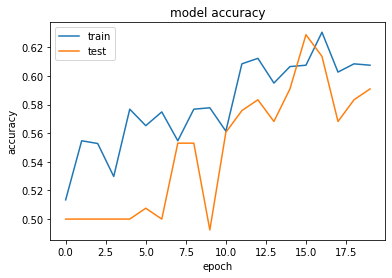

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/content/drive/My Drive/projects/MURA/plots/Multi-CNN-history.png')

In [10]:
# model = load_model("/content/drive/My Drive/projects/MURA/models/multi-input-0,4.h5")
model = load_model("/content/drive/My Drive/projects/MURA/models/multi-input.h5")

In [11]:
final_loss, final_acc = model.evaluate([X_test1_balanced, X_test2_balanced, X_test3_balanced, X_test4_balanced], y_test_cat, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))  

5/5 [==============================] - 0s 65ms/step - loss: 0.6289 - accuracy: 0.6364
Final loss: 0.628949, final accuracy: 0.636364


In [12]:
#ANALYSIS ON VALIDATION SET
from sklearn.metrics import cohen_kappa_score

pred = model.predict([X_test1_balanced, X_test2_balanced, X_test3_balanced, X_test4_balanced])

#convert array with values of form [[0.4, 0.6],...,[0.9, 0.1]] to [1,0] 
y_hat = np.zeros(len(pred))
for i in range(len(pred)):
    y_hat[i] = np.argmax(pred[i])

kappa = cohen_kappa_score(y_test_balanced, y_hat)
print ("cohen-kappa score is", kappa)

score = model.evaluate([X_test1_balanced, X_test2_balanced, X_test3_balanced, X_test4_balanced], y_test_cat, verbose=0)
print("metrics are", model.metrics_names)
print("respective scores are", score)

cohen-kappa score is 0.2727272727272727
metrics are ['loss', 'accuracy']
respective scores are [0.6289494037628174, 0.6363636255264282]
